# Project<br>Medical Appointment No Shows Data Investigation

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This report analyses a [dataset](https://www.kaggle.com/joniarroba/noshowappointments) of more than 110k Brazilian patients from late April to early June 2016. Data shows that in 20% of scheduled appointments, the patient didn't show up.
> Our goal is trying to answer the question:<br> ***what are the factors leading to no_shows?<br> Is it the system or personal attributes to blame?***  

> The report distinguishes between two groups of factors that might have significance: those related to the system, and personal attributes of the patients themselves.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from datetime import datetime
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> In this section, we will load in the data, check for cleanliness, and then trim and clean your dataset for analysis.

### General Properties

In [2]:
# first let's load the data into a dataframe
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

Let's have a look at the first few rows of the data using`.head()`:

In [3]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Display info about each column using `.info()` method.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


We notice that we have no bools. We also notice that some columns has *object* dtype instead of *str*, this is because Pandas stores pointers to strings in dataframes and series.<br>
We can confirm that these objects are indeed strings with the following command:

In [5]:
[type(df['Gender'][0]), type(df['ScheduledDay'][0]), type(df['AppointmentDay'][0]), type(df['Neighbourhood'][0]), type(df['No-show'][0])]

[str, str, str, str, str]

Now let's check for null and duplicated values.

In [6]:
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [7]:
df.duplicated().sum()

0

We have no nulls nor duplicates, which is great.

Let's look further into the data, check unique values for each column.

In [8]:
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

We first notice that there are many *Neighbourhood* values in our data, this makes it less useful in our analysis.

The second observation is that most columns are binary variables (categorical variables that  take only two values), including our dependent variable *(No-Show)*. This will affect our Exploratory Data Analysis, pie and bar charts will be more useful than histograms in most cases.

We also notice that ***Handcap*** have 5 unique values, according to [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments) it should be 2 (0 or 1). let's investigate that further.

In [9]:
# function to get unique values
def unique(data):
 
    unique = []
     
    for v in data:
        if v not in unique:
            unique.append(v)

    for v in unique:
        print(v)

In [10]:
unique(df['Handcap'])

0
1
2
3
4


***Handcap*** values ranges from 0 to 4, I can think of two reasons for that:
- The system have 4 degrees of Handicaps: 1-4 , plus 0 for none.
- These are input errors.

Let's check how many strange values we have:

In [11]:
collections.Counter(df['Handcap'])

Counter({0: 108286, 1: 2042, 2: 183, 3: 13, 4: 3})

The number of values of 2 or more are very few (less than 200 values), so they're probably **input errors**.

Finally, let's review some descriptive statistics of our data:

In [12]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


Why is the minimum value of 'Age' is -1? this is an input error. Let's investigate:

In [13]:
collections.Counter(df['Age']<0)

Counter({False: 110526, True: 1})

We have only one input error in 'Age' column.

### Data Cleaning

Let's start by cleaning input errors in 'Handcap' and 'Age' columns.

'Age' has only one input error of -1, we will replace it with 0:

In [14]:
df.Age.replace(to_replace=-1, value=0, inplace=True, limit=None, regex=False, method='pad')
collections.Counter(df['Age']<0)

Counter({False: 110527})

Now for 'Handcap', since 1 stands for handicaps = True, these positive errors are most likely should have been 1. Although changing these inputs to 1 will increase the number of people in this category by 10%; they still represent very a small percentage of the whole dataset (2%), so this will probably have little effect.

In [15]:
df.Handcap.replace(to_replace=[2, 3, 4], value=1, inplace=True, limit=None, regex=False, method='pad')
collections.Counter(df['Handcap'])

Counter({0: 108286, 1: 2241})

Before continuing our cleaning, we need to think about what we need from the dataset. The report explores ***'No-show'*** as a dependent variable. As for my choices of the independent variables, there are two groups:

**1. Variables related to the system:** (Scholarship, SMS_received, if ScheduledDay == AppointmentDay).<br>
**2. Variables related to the patient:** (Age, Gender, Medical conditions).

This requires creating a new variable to check if `ScheduledDay == AppointmentDay`. We can use datetime library, but since both 'ScheduledDay' and 'AppointmentDay' columns are in ISO 8601 standard format, it's much simpler to use string slicing.

In [16]:
# this is how to create a new list of ScheduledDay == AppointmentDay bool
# first, create lists of ScheduledDay and AppointmentDay series
ScheduledDay = list(df['ScheduledDay'])
AppointmentDay = list(df['AppointmentDay'])

# next, create a combined list of them
dates = list(zip(ScheduledDay, AppointmentDay))
dates[:10]

[('2016-04-29T18:38:08Z', '2016-04-29T00:00:00Z'),
 ('2016-04-29T16:08:27Z', '2016-04-29T00:00:00Z'),
 ('2016-04-29T16:19:04Z', '2016-04-29T00:00:00Z'),
 ('2016-04-29T17:29:31Z', '2016-04-29T00:00:00Z'),
 ('2016-04-29T16:07:23Z', '2016-04-29T00:00:00Z'),
 ('2016-04-27T08:36:51Z', '2016-04-29T00:00:00Z'),
 ('2016-04-27T15:05:12Z', '2016-04-29T00:00:00Z'),
 ('2016-04-27T15:39:58Z', '2016-04-29T00:00:00Z'),
 ('2016-04-29T08:02:16Z', '2016-04-29T00:00:00Z'),
 ('2016-04-27T12:48:25Z', '2016-04-29T00:00:00Z')]

Now we create a list of our desired bool

In [17]:
same_test = []
for sday, aday in dates:
    same = sday[5:10] == aday[5:10]
    same_test.append(same)
same_test[:10]

[True, True, True, True, True, False, False, False, True, False]

let's convert `same_test` values to 1 or 0 to be consistent with the data.

In [18]:
sameday = []
for v in same_test:
    if v == True:
        v = 1
    else:
        v = 0
    sameday.append(v)
sameday[:10]

[1, 1, 1, 1, 1, 0, 0, 0, 1, 0]

Now let's append `samaday` to df, we need to create a numpy array, then append it to `df`.

In [19]:
sameday = np.array(sameday)
df['SameDay'] = sameday
df['SameDay']

0         1
1         1
2         1
3         1
4         1
         ..
110522    0
110523    0
110524    0
110525    0
110526    0
Name: SameDay, Length: 110527, dtype: int64

We will drop all columns that we don't need.

In [20]:
df.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay','Neighbourhood'], axis=1, inplace=True)

`No-show` is a bad name to a variable, let's change that. We will also change columns to lowercase.

In [21]:
df.rename(columns={'No-show':'Noshow'}, inplace=True)
df= df.rename(columns=str.lower)

Now, let's rearrange the columns:

In [22]:
cols = df.columns.tolist()
cols

['gender',
 'age',
 'scholarship',
 'hipertension',
 'diabetes',
 'alcoholism',
 'handcap',
 'sms_received',
 'noshow',
 'sameday']

In [23]:
cols = ['noshow', 'gender', 'age', 'hipertension', 'diabetes', 'alcoholism', 'handcap',
 'scholarship', 'sms_received','sameday']
df = df[cols]
df.head()

,noshow,gender,age,hipertension,diabetes,alcoholism,handcap,scholarship,sms_received,sameday
0,No,F,62,1,0,0,0,0,0,1
1,No,M,56,0,0,0,0,0,0,1
2,No,F,62,0,0,0,0,0,0,1
3,No,F,8,0,0,0,0,0,0,1
4,No,F,56,1,1,0,0,0,0,1


Finally, let's convert `noshow` and `gender` to dummy variables (change values to 0 and 1) so we can calculate the correlation coefficients. 

In [24]:
df.noshow.replace(to_replace=['No', 'Yes'], value=[0, 1], inplace=True, limit=None, regex=False, method='pad')
df.gender.replace(to_replace=['F', 'M'], value=[0, 1], inplace=True, limit=None, regex=False, method='pad')

This is our **cleaned DataFrame**:

In [25]:
df.head()

,noshow,gender,age,hipertension,diabetes,alcoholism,handcap,scholarship,sms_received,sameday
0,0,0,62,1,0,0,0,0,0,1
1,0,1,56,0,0,0,0,0,0,1
2,0,0,62,0,0,0,0,0,0,1
3,0,0,8,0,0,0,0,0,0,1
4,0,0,56,1,1,0,0,0,0,1


<a id='eda'></a>
## Exploratory Data Analysis

> Now that we've trimmed and cleaned the data, we're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions.

> It's important to note that this analysis focus is on the correlation between our variables. This is not enough to assume there is a causal relation between. Further studies using inferential statistics is required for that.

The main problem that this report discuss is the high rate of no_show patient in the Brazilian healthcare system. Let's explore our dependent variable **`noshow`**.

First, let's create masks according to noshow values

In [26]:
miss = df.noshow == 1
show = df.noshow == 0

Explore `noshow` variable with a pie chart using `matplotlib`.

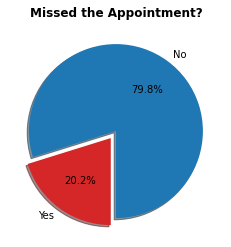

In [27]:
# plotting the pie chart
plt.pie(df['noshow'].value_counts(), labels = ['No', 'Yes'], colors=['tab:blue', 'tab:red'], 
        startangle=270, shadow = True, explode = (0, 0.1),
        radius = 1.0, autopct = '%1.1f%%')
# plot title
plt.title('Missed the Appointment?', fontweight="bold")
# showing the plot
plt.show()

More than 20% of scheduled appointments had no_shows, why?

Let's start to check the correlation matrix:

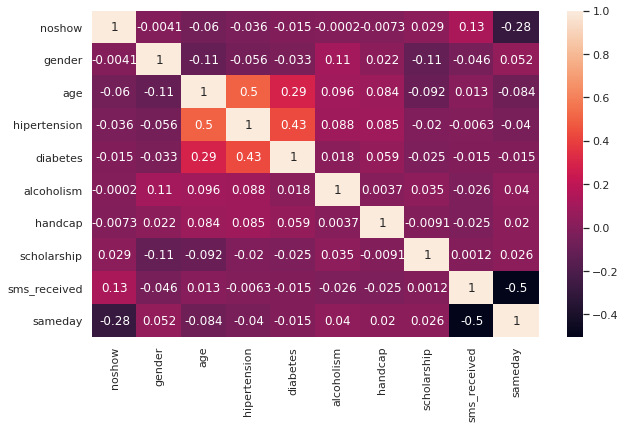

In [28]:
corrMatrix = df.corr()
sns.set(rc={'figure.figsize':(10,6)})
sns.heatmap(corrMatrix, annot=True)
plt.show()

Now to our questions.

### Research Question 1<br> Is the System Responsible for the High Rate of No-Shows

We will investigate three variables: `scholarship`, `sms_received` and `sameday`.

#### 1. Scholarship (Bolsa Família)

[Bolsa Família](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia) is a social welfare program of the Government of Brazil. It provides financial aid to poor Brazilian families.

`scholarship = 1` for patients who receive funds from this program.<br> This totals to 9.8% of the dataset as shown in the pie chart below:

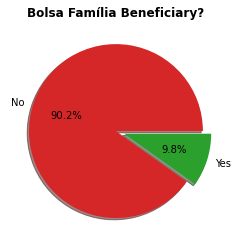

In [29]:
# first line resets seaborn charts to original size
sns.reset_orig()

plt.pie(df['scholarship'].value_counts(), labels = ['No', 'Yes'], colors=['tab:red', 'tab:green'], 
        startangle=0, shadow = True, explode = (0, 0.1),
        radius = 1.0, autopct = '%1.1f%%')

plt.title('Bolsa Família Beneficiary?', fontweight="bold")

plt.show()

The correlation coefficient between `scholarship` and `noshow` is very low `0.029`. We can't notice differences in the no_show rate between those who benefit from 'Bolsa Família' and those who don't.

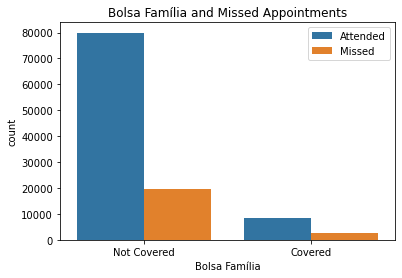

In [30]:
ax = sns.countplot(x="scholarship", hue="noshow", data=df)
ax.set(title='Bolsa Família and Missed Appointments')
plt.xticks([0, 1], ['Not Covered', 'Covered'])
ax.set_xlabel('Bolsa Família')
L=plt.legend()
L.get_texts()[0].set_text('Attended')
L.get_texts()[1].set_text('Missed')
plt.show()

#### 2. SMS_Received

Does sending SMS reminders to a patient decrease the chance of no_show? 32.1% of our dataset received an SMS as shown here: 

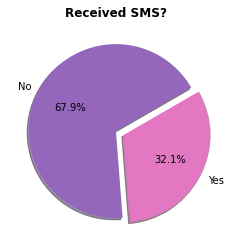

In [31]:
plt.pie(df['sms_received'].value_counts(), labels = ['No', 'Yes'], colors=['tab:purple', 'tab:pink'], 
        startangle=30, shadow = True, explode = (0, 0.1),
        radius = 1.0, autopct = '%1.1f%%')

plt.title('Received SMS?', fontweight="bold")
    
plt.show()

There is a very weak positive correlation between `noshow` and `sms_received`:

In [32]:
df['noshow'].corr(df['sms_received'])

0.1264306575731448

Since `noshow = 1` in the case of no_show. This means there is a slight higher chance of no_show for those who received an SMS.

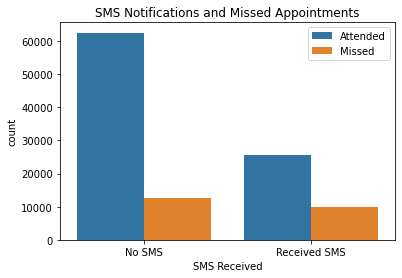

In [33]:
ax = sns.countplot(x="sms_received", hue="noshow", data=df)
ax.set(title='SMS Notifications and Missed Appointments')
plt.xticks([0, 1], ['No SMS', 'Received SMS'])
ax.set_xlabel('SMS Received')
L=plt.legend()
L.get_texts()[0].set_text('Attended')
L.get_texts()[1].set_text('Missed')
plt.show()

#### 3. Scheduled for the Same Day

If the patients got their appointment at the same day of booking, will that make them less likley to miss?<br>
34.9% got their appointment on the same day.

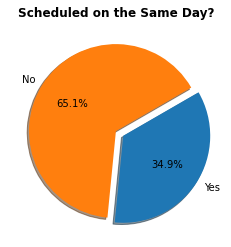

In [34]:
plt.pie(df['sameday'].value_counts(), labels = ['No', 'Yes'], colors=['tab:orange', 'tab:blue'], 
        startangle=30, shadow = True, explode = (0, 0.1),
        radius = 1.0, autopct = '%1.1f%%')
  
plt.title('Scheduled on the Same Day?', fontweight="bold")
     
plt.show()

There is a negative correlation between `noshow` and `sameday`.

In [35]:
df['noshow'].corr(df['sameday'])

-0.28348640643405854

Though the correlation is somewhat weak, it's the highest in the correlation matrix.

This negative correlation means that patients who got their appointments on the same day are less likely to miss.

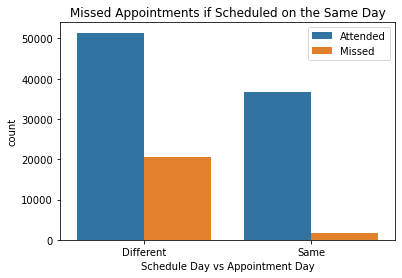

In [36]:
ax = sns.countplot(x="sameday", hue="noshow", data=df)
ax.set(title='Missed Appointments if Scheduled on the Same Day')
plt.xticks([0, 1], ['Different', 'Same'])
ax.set_xlabel('Schedule Day vs Appointment Day')
L=plt.legend()
L.get_texts()[0].set_text('Attended')
L.get_texts()[1].set_text('Missed')
plt.show()

### Research Question 2<br> Are Patients' Attributes Responsible for the High Rate of No-Shows

Now we will investigate `Age`, `Gender` and `four medical conditions` for the patients.

#### 1. Age

`age` is our only numerical variable in the dataset. Let's start by checking its histogram.

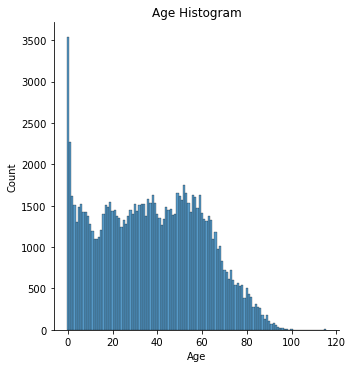

In [37]:
ax=sns.displot(df, x="age", discrete=True).set(title='Age Histogram', xlabel='Age');

The number of newborn and children up to 4 years is considerably higher, let's investigate further:

In [38]:
collections.Counter(df['age']<=4)

Counter({False: 100284, True: 10243})

This is `age` boxplot:

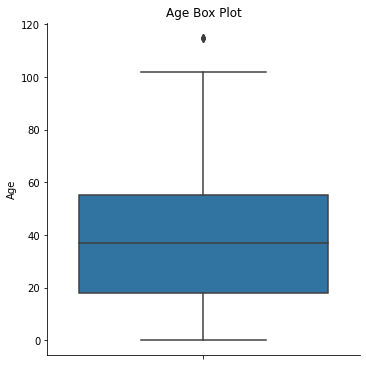

In [39]:
sns.catplot(y="age", kind="box", data=df).set(title='Age Box Plot', ylabel='Age');
plt.show()

There is almost no correlation between `noshow` and `age`.

In [40]:
df['noshow'].corr(df['age'])

-0.0603187467493542

We can still comare the age of our two groups:

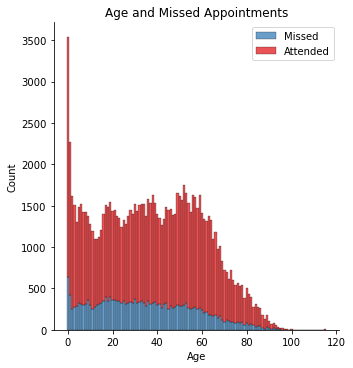

In [41]:
# both histograms on the same plot
ax=sns.displot(df, x="age", hue="noshow", multiple="stack", discrete=True, legend=False, palette="Set1").set(title='Age and Missed Appointments', xlabel='Age');
plt.legend(labels=["Missed","Attended"])
plt.show()

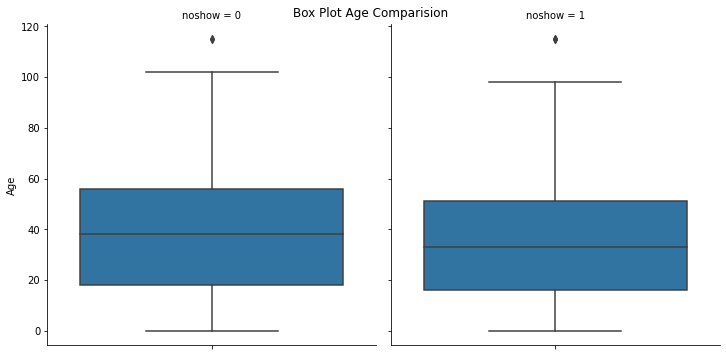

In [42]:
# boxplot for each group
ax=sns.catplot(y="age", col="noshow",kind="box", data=df);
ax.set_axis_labels("", "Age")
ax.fig.suptitle('Box Plot Age Comparision');

From the above boxplot and the below code, we find that patients who missed their appointments are younger (on average) than those who showed.

In [43]:
[df.age[miss].mean(), df.age[show].mean()]

[34.31766656212196, 37.79007573009251]

#### 2. Gender

`gender` takes 0 for females, and 1 for males. Female patients formed 65% of the dataset.

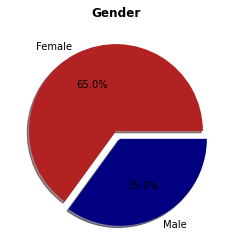

In [44]:
plt.pie(df['gender'].value_counts(), labels = ['Female', 'Male'], colors=['firebrick', 'navy'], 
        startangle=0, shadow = True, explode = (0, 0.1),
        radius = 1.0, autopct = '%1.1f%%')

plt.title('Gender', fontweight="bold")

plt.show()

There is no correlation between `noshow` and `gender`

In [45]:
df['noshow'].corr(df['gender'])

-0.004118633199373613

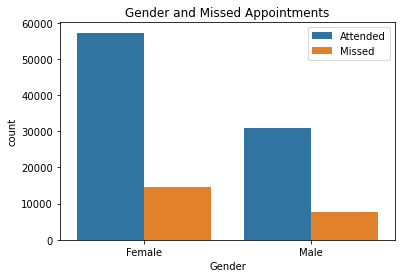

In [46]:
ax = sns.countplot(x="gender", hue="noshow", data=df)
ax.set(title='Gender and Missed Appointments')
plt.xticks([0, 1], ['Female', 'Male'])
ax.set_xlabel('Gender')
L=plt.legend()
L.get_texts()[0].set_text('Attended')
L.get_texts()[1].set_text('Missed')
plt.show()

Data shows that `gender` is not a decisive factor in our question.

#### 3. Health Condition

We have four types of health problems in our dataset. Of those, we will examine `hipertension` and `diabetes`, based on their prevalence and the correlation matrix.

#### I. Hypertension

19.7% of patients had hypertension, but there is no correlation with `noshow`.

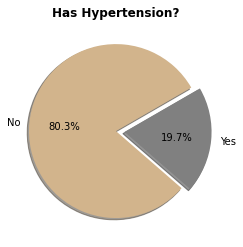

In [47]:
plt.pie(df['hipertension'].value_counts(), labels = ['No', 'Yes'], colors=['tan', 'grey'], 
        startangle=30, shadow = True, explode = (0, 0.1),
        radius = 1.0, autopct = '%1.1f%%')
  
plt.title('Has Hypertension?', fontweight="bold")
     
plt.show()

In [48]:
df['noshow'].corr(df['hipertension'])

-0.03570117734501481

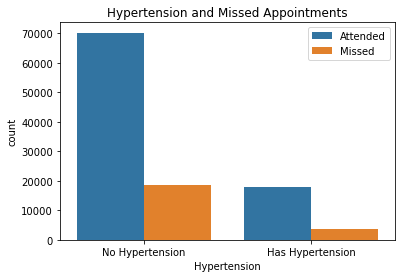

In [49]:
ax = sns.countplot(x="hipertension", hue="noshow", data=df)
ax.set(title='Hypertension and Missed Appointments')
plt.xticks([0, 1], ['No Hypertension', 'Has Hypertension'])
ax.set_xlabel('Hypertension')
L=plt.legend()
L.get_texts()[0].set_text('Attended')
L.get_texts()[1].set_text('Missed')
plt.show()

#### II. Diabetes

7.2% of patients had diabetes, but there is no correlation with `noshow`.


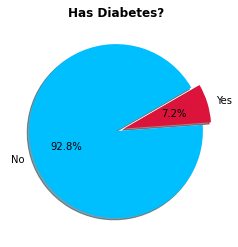

In [50]:
plt.pie(df['diabetes'].value_counts(), labels = ['No', 'Yes'], colors=['deepskyblue', 'crimson'], 
        startangle=30, shadow = True, explode = (0, 0.1),
        radius = 1.0, autopct = '%1.1f%%')
  
plt.title('Has Diabetes?', fontweight="bold")
     
plt.show()

In [51]:
df['noshow'].corr(df['diabetes'])

-0.015179943820773829

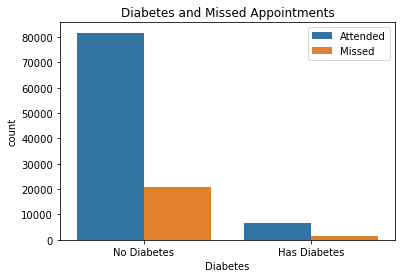

In [52]:
ax = sns.countplot(x="diabetes", hue="noshow", data=df)
ax.set(title='Diabetes and Missed Appointments')
plt.xticks([0, 1], ['No Diabetes', 'Has Diabetes'])
ax.set_xlabel('Diabetes')
L=plt.legend()
L.get_texts()[0].set_text('Attended')
L.get_texts()[1].set_text('Missed')
plt.show()

What if a patient has both hypertension and diabetes, will that affect the chance of no_show? Let's investigate:

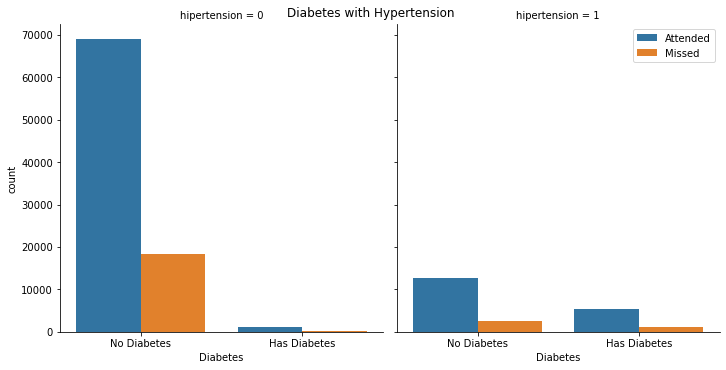

In [53]:
ax = sns.catplot(x="diabetes", hue="noshow", col="hipertension", kind="count", data=df, legend=False)
ax.set_axis_labels("Diabetes", "count")
plt.xticks([0, 1], ['No Diabetes', 'Has Diabetes'])
L=plt.legend()
L.get_texts()[0].set_text('Attended')
L.get_texts()[1].set_text('Missed')
ax.fig.suptitle('Diabetes with Hypertension');

Actually, if a patient suffer from both illnesses, he much less likely to miss the appointment.

<a id='conclusions'></a>
## Conclusions

### Results
> This report examined a dataset of Brazilian patients, trying to figure out what are the factors that correlates with missing appointments.

> It found that the most important factor was whether the patient got his appointment at the same day of booking. This factor was negatively correlated with no_show cases, meaning that there were less no_shows when the patient was scheduled on the same day.

> Regarding the system, the report found that sending SMS notifications didn't help. In fact, it was weakly positively correlated with no_show cases. Implying that those who received an SMS were slightly more likely to miss. Receiving benefits from Bolsa Família didn't seem to correlate with no_show cases.

> Personal attributes didn't seem to correlate with no_shows. Except that patients who missed their appointments were younger in general of those who didn't. It is also noted that having multiple illnesses seems to correlate with less no_shows.

### Limitations

> Most columns in the dataset are binary variables (categorical variables that take only two values), including the dependent variable `noshow`. This limits the statistical methods that can be used to analyze the data.

> Some results were counter-intuitive, The analysis found that there is a slight higher chance of no_show for those who received an SMS. The nature of the data prevents further investigation.

> It's important to note that this analysis focus is on the correlation between the variables. This is not enough to assume there is a causal relation between them. Further studies using inferential statistics is required for that. Also, most correlations were weak due to the categorical nature of the variables.